# Using ADAM-API to access UERRA regional reanalysis

- you need to get an account to https://reliance.adamplatform.eu/ (use ORCID to authenticate) and key your ADAM API key
- make sure you save your ADAM API key in a file `$HOME/adam-key`

In [1]:
!pip install adamapi

In [2]:
import os
import glob
import pathlib
import zipfile
import adamapi as adam
import xarray as xr
from datetime import datetime
import matplotlib
import cartopy.crs as ccrs
from cmcrameri import cm

In [3]:
adam_key = open(os.path.join(os.environ['HOME'],"adam-key")).read().rstrip()

In [4]:
a = adam.Auth()

a.setKey(adam_key)
a.setAdamCore('https://reliance.adamplatform.eu')
a.authorize()

{'expires_at': '2021-10-19T15:58:51.934Z',
 'access_token': 'cfe0ed4d1ce94333814478fc77c323b4',
 'refresh_token': '93f51e708ce4470092a426ed8c071523',
 'expires_in': 3600}

## Discover UERRA datasets 
- This step is useful to get the dataset identifier (unique for a given datacube)

In [5]:
def discoverDasasets(a, search_name):
    datasets = adam.Datasets(a)
    catalogue = datasets.getDatasets()
    #Extracting the size of the catalogue
    total = catalogue['properties']['totalResults']
    items = catalogue['properties']['itemsPerPage']
    pages = total//items
    
    print('----------------------------------------------------------------------')
    print('\033[1m' + 'List of available datasets:')
    print ('\033[0m')

    #Extracting the list of datasets across the whole catalogue
    for i in range(0,pages):
        page = datasets.getDatasets(page = i)
        for element in page['content']: 
            if search_name in element['title'] :
                print(element['title'] + "\033[1m" + " --> datasetId "+ "\033[0m" + "= " + element['datasetId'])
    return datasets

In [6]:
datasets = discoverDasasets(a, 'UERRA')

----------------------------------------------------------------------
List of available datasets:

UERRA_2M_TEMPERATURE --> datasetId = 71114:UERRA_2M_TEMPERATURE
UERRA_ALBEDO --> datasetId = 80984:UERRA_ALBEDO
UERRA_OROGRAPHY --> datasetId = 80985:UERRA_OROGRAPHY
UERRA_SKIN_TEMPERATURE --> datasetId = 80982:UERRA_SKIN_TEMPERATURE
UERRA_SNOW_DENSITY --> datasetId = 71100:UERRA_SNOW_DENSITY


## Get metadata from Snow density

In [7]:
datasetID = '71100:UERRA_SNOW_DENSITY'

print('\033[1;34m' + 'Metadata of ' + datasetID + ':')
print ('\033[0;0m')

paged = datasets.getDatasets(datasetID)
for i in paged.items():
    print("\033[1m" +  str(i[0]) + "\033[0m" + ': ' + str(i[1]))

Metadata of 71100:UERRA_SNOW_DENSITY:

datasetId: 71100:UERRA_SNOW_DENSITY
creationDate: 2018-07-31T00:00:00Z
dataType: Float32
epsg: 4326
keywords: []
license: {'documentationUrl': '', 'dataProviderName': 'ECMWF', 'dataProviderUrl': '', 'licenseId': '', 'dataPolicy': '', 'doi': '', 'credits': ''}
maxValue: [300.0]
minValue: [0.0]
noDataValue: -9999
numberOfRecords: 60251
profile: {'profileSchema': 'eo_profile_schema.json', 'name': 'Earth Observation', 'mission': 'UERRA', 'sensor': 'UERRA', 'processingLevel': 'L1', 'instrument': '', 'platform': ''}
resolutionUnit: degree
temporalResolution: Daily
unit: 
unitDescription: 
updateDate: 2021-08-31T09:29:26Z
geometry: {'type': 'Polygon', 'coordinates': [[[-179.9940193, -88.9158823], [180.0, -88.9158823], [180.0, 89.0841177], [-179.9940193, 89.0841177], [-179.9940193, -88.9158823]]]}
resolutions: [0.1]
anyText: 4326,ESA,Daily,ESA
applications: ['Atmosphere']
datasetManager: mantovani@meeo.it
datasetManagerOrganisation: meeo
description: UERR

## Discover and select products from a dataset
- for a given time range and spatial coverage

### Get data over the Nordics countries
- The geometry field is extracted from a GeoJSON object , retrieving the value of the "feature" element.

#### Search data
- only print the first 10 products
- UERRA reanalysis are provided 4 times a day (00, 06, 12, 18 UTC)

In [8]:
!pip install geojson_rewind

In [9]:
from adamapi import Search
from geojson_rewind import rewind
import json

The GeoJson object needs to be rearranged according to the counterclockwise winding order.This operation is executed in the next few lines to obtain a geometry that meets the requirements of the method. Geom_1 is the final result to be used in the discovery operation.
- you can go to https://geojson.io/ to draw an area of interest (save the produced geojson to a file)

In [10]:
with open('nordics.geojson') as f:
    geom_dict = json.load(f)
output = rewind(geom_dict)    
geom_1 = str(geom_dict['features'][0]['geometry'])

In [11]:
geom_1

"{'type': 'Polygon', 'coordinates': [[[2.021484375, 54.36775852406841], [42.626953125, 54.36775852406841], [42.626953125, 71.88357830131248], [2.021484375, 71.88357830131248], [2.021484375, 54.36775852406841]]]}"

In [12]:
start_date = '2015-01-01T00:00:00Z'
end_date = '2015-12-31T00:00:00Z'

In [13]:
search = Search( a )
results = search.getProducts(
    datasetID, 
    geometry= geom_1,
    startDate = start_date,
    endDate = end_date
 )

# Printing the results

print('\033[1m' + 'List of available products:')
print ('\033[0m')
count = 1
for i in results['content']:

        print("\033[1;31;1m" + "#" + str(count))
        print ('\033[0m')
        for k in i.items():
            print(str(k[0]) + ': ' + str(k[1]))
        count = count+1
        print('------------------------------------')

List of available products:

#1

_id: {'$oid': '612df2f0d57e43c6680b3b62'}
datasetId: UERRA_SNOW_DENSITY
productDate: 2015-12-31T00:00:00Z
productId: UERRA_SNOW_DENSITY_20151231000000.tif
geometry: {'geometries': [{'type': 'Polygon', 'coordinates': [[[-0.0940193, -88.9158823], [178.9059807, -88.9158823], [178.9059807, 89.0841177], [-0.0940193, 89.0841177], [-0.0940193, -88.9158823]]]}], 'type': 'GeometryCollection'}
insertDate: 2021-08-31T09:14:24Z
status: Online
------------------------------------
#2

_id: {'$oid': '612df2efd57e43c6680b3b16'}
datasetId: UERRA_SNOW_DENSITY
productDate: 2015-12-30T18:00:00Z
productId: UERRA_SNOW_DENSITY_20151230180000.tif
geometry: {'geometries': [{'type': 'Polygon', 'coordinates': [[[-0.0940193, -88.9158823], [178.9059807, -88.9158823], [178.9059807, 89.0841177], [-0.0940193, 89.0841177], [-0.0940193, -88.9158823]]]}], 'type': 'GeometryCollection'}
insertDate: 2021-08-31T09:14:23Z
status: Online
------------------------------------
#3

_id: {'$oid': '

## Get data
- be aware that you alwasy get daily average from ADAM-API 

In [14]:
def getZipData(auth, dataset_info):
    if not (pathlib.Path(pathlib.Path(dataset_info['outputFname']).stem).exists() or pathlib.Path(dataset_info['outputFname']).exists()):
        data = adam.GetData(auth)
        image = data.getData(
        datasetId = dataset_info['datasetID'],
        startDate = dataset_info['startDate'],
        endDate = dataset_info['endDate'],
        geometry = dataset_info['geometry'],
        outputFname = dataset_info['outputFname'])
        print(image)

In [15]:
%%time

output_file = './UERRA_SNOW_DENSITY_SWE_ADAMAPI_' + start_date + '-' + end_date + '.zip'

datasetInfo = {
    'datasetID'   : datasetID,
    'startDate'   : start_date,
    'endDate'     : end_date,
    'geometry'    : geom_1,
    'outputFname' : output_file
    }
getZipData(a, datasetInfo)

CPU times: user 148 µs, sys: 0 ns, total: 148 µs
Wall time: 154 µs


## Data analysis and Visualization

### Unzip data 

In [16]:
def unzipData(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(path = pathlib.Path(filename).stem)

In [17]:
if not pathlib.Path(pathlib.Path(output_file).stem).exists():
    unzipData(output_file)

## Read data in xarray

In [18]:
def paths_to_datetimeindex(paths):
    return  [datetime.strptime(date.split('_')[-1].split('.')[0], '%Y-%m-%dt%f') for date in paths]

In [19]:
def getData(dirtif, varname):
    geotiff_list = glob.glob(dirtif)
    # Create variable used for time axis
    time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list))
    # Load in and concatenate all individual GeoTIFFs
    geotiffs_da = xr.concat([xr.open_rasterio(i, parse_coordinates=True) for i in geotiff_list],
                        dim=time_var)
    # Covert our xarray.DataArray into a xarray.Dataset
    geotiffs_da = geotiffs_da.to_dataset('band')
    # Rename the dimensions to make it CF-convention compliant
    geotiffs_da = geotiffs_da.rename_dims({'y': 'latitude', 'x':'longitude'})
    # Rename the variable to a more useful name
    geotiffs_da = geotiffs_da.rename_vars({1: varname, 'y':'latitude', 'x':'longitude'})
    # set attribute to variable
    geotiffs_da[varname].attrs = {'units' : geotiffs_da.attrs[varname + '#units'], 'long_name' : geotiffs_da.attrs[varname + '#long_name']}
    return geotiffs_da

In [20]:
path_files = os.path.join(pathlib.Path(output_file).stem, '*.tif')
geotiff_ds = getData(path_files, 'rsn')

In [21]:
geotiff_ds

<xarray.Dataset>
Dimensions:    (latitude: 176, longitude: 407, time: 365)
Coordinates:
  * latitude   (latitude) float64 71.83 71.73 71.63 71.53 ... 54.53 54.43 54.33
  * longitude  (longitude) float64 2.056 2.156 2.256 2.356 ... 42.46 42.56 42.66
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Data variables:
    rsn        (time, latitude, longitude) float32 -9.999e+03 ... -9.999e+03
Attributes: (12/57)
    transform:                                    (0.1, 0.0, 2.00598068127238...
    crs:                                          +init=epsg:4326
    res:                                          (0.1, 0.1)
    is_tiled:                                     0
    nodatavals:                                   (-9999.0,)
    scales:                                       (1.0,)
    ...                                           ...
    rsn#units:                                    kg m**-3
    rsn#_FillValue:                               nan
    time#calendar:                                proleptic_gregorian
    time#long_name:                               initial time of forecast
    time#standard_name:                           forecast_reference_time
    time#units:                                   seconds since 1970-01-01

## Analysis
- generate seasonal average

In [22]:
geotiff_dm = geotiff_ds.groupby('time.season').mean('time', keep_attrs=True, skipna = True)

In [23]:
geotiff_dm

<xarray.Dataset>
Dimensions:    (latitude: 176, longitude: 407, season: 4)
Coordinates:
  * latitude   (latitude) float64 71.83 71.73 71.63 71.53 ... 54.53 54.43 54.33
  * longitude  (longitude) float64 2.056 2.156 2.256 2.356 ... 42.46 42.56 42.66
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    rsn        (season, latitude, longitude) float32 -9.999e+03 ... -9.999e+03
Attributes: (12/57)
    transform:                                    (0.1, 0.0, 2.00598068127238...
    crs:                                          +init=epsg:4326
    res:                                          (0.1, 0.1)
    is_tiled:                                     0
    nodatavals:                                   (-9999.0,)
    scales:                                       (1.0,)
    ...                                           ...
    rsn#units:                                    kg m**-3
    rsn#_FillValue:                               nan
    time#calendar:                                proleptic_gregorian
    time#long_name:                               initial time of forecast
    time#standard_name:                           forecast_reference_time
    time#units:                                   seconds since 1970-01-01

/opt/conda/lib/python3.8/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


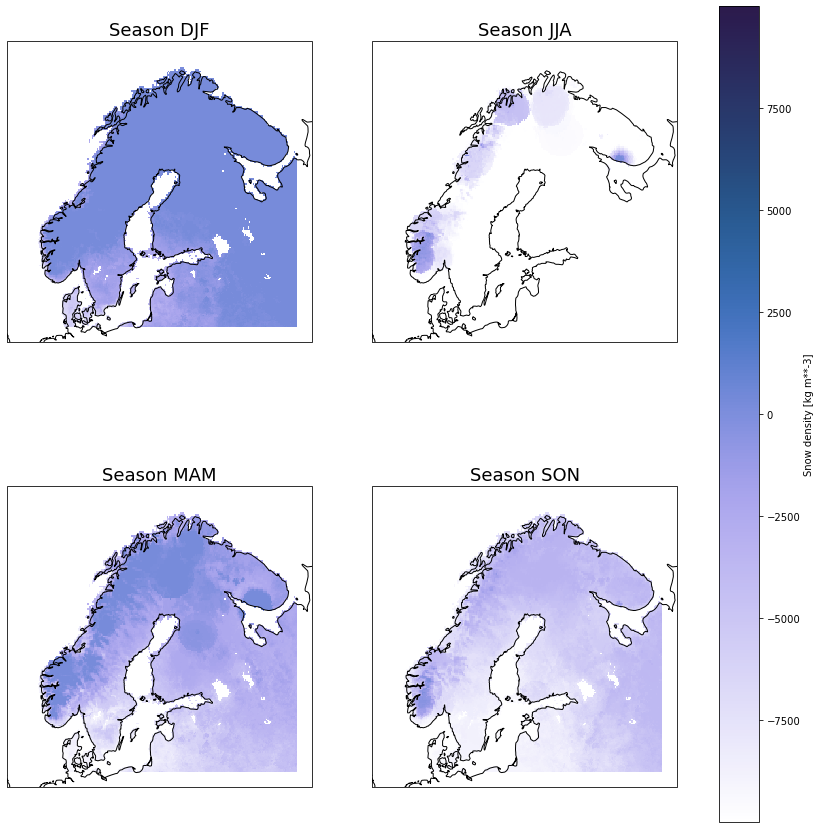

In [24]:
proj_plot = ccrs.Mercator()

p = geotiff_dm['rsn'].plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(),
                             aspect=geotiff_dm.dims["longitude"] / geotiff_dm.dims["latitude"],  # for a sensible figsize
                             subplot_kws={"projection": proj_plot},
                             col='season', col_wrap=2, robust=True, cmap=cm.devon_r)
# We have to set the map's options on all four axes
for ax,i in zip(p.axes.flat,  geotiff_dm.season.values):
    ax.coastlines()
    ax.set_title('Season '+i, fontsize=18)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15., 15.)
fig.savefig('UERRA_rsn.png', dpi=100)